In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
import Preprocessing as pre


# Import and Process the Data

In [2]:
# Put your path instead !!!
data_root = "/home/gabriel/Desktop/POLY/PHD/Cours/INF8953CE/Competition/Data/"

X = np.load(data_root + "train_images.npy/train_images.npy", allow_pickle=True, encoding='bytes')
X = np.vstack(X[:, 1])
X = X.astype(np.dtype('u1'))

Y = np.genfromtxt(data_root + "train_labels/train_labels.csv", delimiter=',', skip_header=1, dtype='U')[:, 1]
encoder = LabelEncoder()
Y = encoder.fit_transform(Y).astype('u1')
print(encoder.classes_)

['apple' 'empty' 'moustache' 'mouth' 'mug' 'nail' 'nose' 'octagon'
 'paintbrush' 'panda' 'parrot' 'peanut' 'pear' 'pencil' 'penguin' 'pillow'
 'pineapple' 'pool' 'rabbit' 'rhinoceros' 'rifle' 'rollerskates'
 'sailboat' 'scorpion' 'screwdriver' 'shovel' 'sink' 'skateboard' 'skull'
 'spoon' 'squiggle']


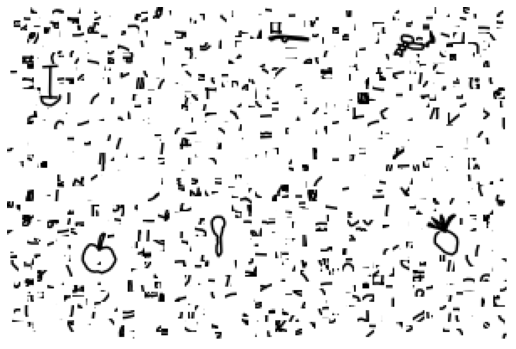

['shovel' 'rifle' 'scorpion' 'apple' 'spoon' 'pineapple']


In [3]:
# Plot 6 different pictures
plt.figure(figsize = (9,9))
pre.plot_digits( X[:6] )
print(encoder.inverse_transform(Y[:6]))

### Crop the Images Edges (If necessary)

In [4]:
X = pre.crop_images(X, reduce = 2)
print(X.shape)


(10000, 9216)


### Data Augmentation

In [5]:
X = np.vstack( (X, pre.reverse_images(X)) )
Y = np.hstack((Y, Y))
X = np.vstack( (X, pre.translate_images(X, [10, -10, 0, 0], [0, 0, 10, -10])) )
Y = np.hstack((Y, Y, Y, Y, Y))
print(X.shape)
print(Y.shape)


(100000, 9216)
(100000,)


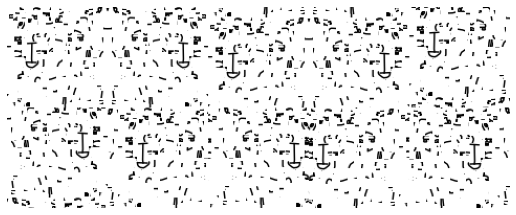

[25 25 25 25 25 25 25 25 25 25]


In [6]:
# Plot different pictures
plt.figure(figsize = (9,9))
pre.plot_digits( X[::10000], images_per_row = 5)
print(Y[::10000])


### Various preprocessing on X

In [7]:
# Data standard scaling
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Data Binarization
X = (X > 50).astype(np.dtype('u1'))

# Sparse matrix
X = csr_matrix(X)


In [8]:
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(X, Y, test_size = 0.1, stratify = Y)

del X, Y


# Baseline Classifier

In [14]:
baselineModel = SGDClassifier(random_state=42)
a_range = np.logspace(-5, -1, 5)
train_score = []
valid_score = []

for a in a_range:
    baselineModel.set_params(alpha = a)
    baselineModel.fit(Xtrain, Ytrain)
    train_score.append(f1_score(baselineModel.predict(Xtrain), Ytrain, average = 'macro'))
    valid_score.append(f1_score(baselineModel.predict(Xvalid), Yvalid, average = 'macro'))
    print(f"Done with alpha = {a}")


Done with alpha = 1e-05
Done with alpha = 0.0001
Done with alpha = 0.001
Done with alpha = 0.01
Done with alpha = 0.1


In [15]:
best_alpha_idx = np.argmax(valid_score)
print(f"Best Performance with alpha = {a_range[best_alpha_idx]:e}")
print(f"Training set F1-measure = {100 * train_score[best_alpha_idx]:.2f}%")
print(f"Validation set F1-measure = {100 * valid_score[best_alpha_idx]:.2f}%")


Best Performance with alpha = 1.000000e-01
Training set F1-measure = 26.42%
Validation set F1-measure = 3.24%


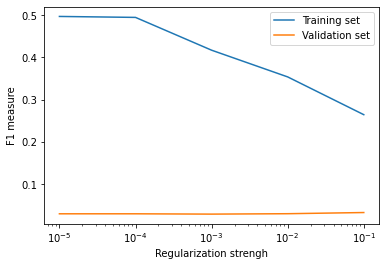

In [16]:
plt.plot(a_range, train_score, label = "Training set")
plt.plot(a_range, valid_score, label = "Validation set")
plt.xlabel("Regularization strengh")
plt.ylabel("F1 measure")
plt.legend()
plt.xscale('log')


# Random Forests

# Convolutionnal Neural Network (CNN)